In [1]:
import os
import torch
import torch.utils.data
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [2]:
class ClimbingDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        
        # Initialize COCO api
        ann_file = os.path.join(root, "_annotations.coco.json")
        if not os.path.exists(ann_file):
            raise FileNotFoundError(f"Annotation file not found at: {ann_file}")

        self.coco = COCO(ann_file)
        # Sort initial keys
        all_ids = list(sorted(self.coco.imgs.keys()))

        # Filter out images that don't exist
        self.ids = []
        missing_count = 0
        for img_id in all_ids:
            img_metadata = self.coco.loadImgs(img_id)[0]
            path = img_metadata['file_name']
            img_path = os.path.join(self.root, path)
            if os.path.exists(img_path):
                self.ids.append(img_id)
            else:
                missing_count += 1
        
        print(f"Total potential images: {len(all_ids)}")
        print(f"Missing images filtered out: {missing_count}")
        print(f"Valid images loaded: {len(self.ids)}")

    def __getitem__(self, index):
        # Load Image
        coco = self.coco
        img_id = self.ids[index]
        img_metadata = coco.loadImgs(img_id)[0]
        path = img_metadata['file_name']
        img_path = os.path.join(self.root, path)
        
        # Image is guaranteed to exist now due to init filtering
        img = Image.open(img_path).convert("RGB")

        # Load Annotations
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        num_objs = len(anns)
        boxes = []
        masks = []
        labels = []

        for ann in anns:
            xmin, ymin, w, h = ann['bbox']
            boxes.append([xmin, ymin, xmin + w, ymin + h])
            labels.append(ann['category_id'])
            masks.append(coco.annToMask(ann))

        # Convert to Tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        if num_objs > 0:
            masks = np.array(masks)
            masks = torch.as_tensor(masks, dtype=torch.uint8)
        else:
            masks = torch.zeros((0, img_metadata['height'], img_metadata['width']), dtype=torch.uint8)
            boxes = torch.zeros((0, 4), dtype=torch.float32)

        image_id = torch.tensor([img_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

In [3]:
# --- Helper Functions ---
def get_transform(train):
    custom_transforms = []
    custom_transforms.append(T.ToTensor())
    return T.Compose(custom_transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

def get_model_instance_segmentation(num_classes):
    model = maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    """Train for one epoch. Returns the average loss.

    The returned value is accumulated in `epoch_losses` so you can plot the
    full loss curve after training.
    """
    model.train()
    running_loss = 0.0
    num_batches  = 0

    for i, (images, targets) in enumerate(data_loader):
        images  = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses    = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        num_batches  += 1

        if i % print_freq == 0:
            print(f"Epoch: {epoch}, Batch: {i}/{len(data_loader)}, Loss: {losses.item():.4f}")

    avg_loss = running_loss / max(num_batches, 1)
    print(f"--- Epoch {epoch} avg loss: {avg_loss:.4f} ---")
    return avg_loss


In [4]:
def visualize_test_predictions(model, dataset_test, device, num_images=4, score_threshold=0.5):
    """Run inference on `num_images` random test images and display
    the predicted bounding boxes and instance masks.

    Args:
        model           : trained Mask R-CNN model
        dataset_test    : ClimbingDataset (test split)
        device          : torch.device
        num_images      : number of test images to visualise
        score_threshold : only show detections above this confidence score
    """
    model.eval()
    n       = min(num_images, len(dataset_test))
    indices = random.sample(range(len(dataset_test)), n)

    fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))
    if n == 1:
        axes = [axes]

    color_map = plt.cm.get_cmap('tab10', 10)

    with torch.no_grad():
        for ax, idx in zip(axes, indices):
            img_tensor, _ = dataset_test[idx]
            prediction    = model(img_tensor.unsqueeze(0).to(device))[0]

            # Tensor → numpy (H, W, 3) in [0,1]
            img_np = img_tensor.permute(1, 2, 0).cpu().numpy().clip(0, 1)
            ax.imshow(img_np)
            ax.set_title(f"Test #{idx}", fontsize=12)
            ax.axis('off')

            scores = prediction['scores'].cpu().numpy()
            boxes  = prediction['boxes'].cpu().numpy()
            masks  = prediction['masks'].cpu().numpy()  # (N, 1, H, W)

            for j, (score, box, mask) in enumerate(zip(scores, boxes, masks)):
                if score < score_threshold:
                    continue
                color = color_map(j % 10)

                # Translucent mask overlay
                mask_bin = mask[0] > 0.5
                overlay  = np.zeros((*mask_bin.shape, 4))
                overlay[mask_bin] = [*color[:3], 0.4]
                ax.imshow(overlay)

                # Bounding box rectangle
                x1, y1, x2, y2 = box
                ax.add_patch(patches.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1,
                    linewidth=2, edgecolor=color, facecolor='none'
                ))
                # Confidence score label
                ax.text(x1, max(y1 - 4, 0), f"{score:.2f}",
                        color='white', fontsize=9,
                        bbox=dict(facecolor=color, alpha=0.7, pad=1, edgecolor='none'))

    plt.suptitle('Mask R-CNN — Test Set Predictions', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [5]:
dataset_path = 'Hold Detector.v2i.coco-segmentation'
train_path   = os.path.join(dataset_path, 'train')
test_path    = os.path.join(dataset_path, 'test')

device      = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # background + hold

print('Initializing datasets...')
dataset_train = ClimbingDataset(train_path, get_transform(train=True))
dataset_test  = ClimbingDataset(test_path,  get_transform(train=False))

data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, collate_fn=collate_fn
)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn
)

print('Loading model...')
model = get_model_instance_segmentation(num_classes)
model.to(device)

params       = [p for p in model.parameters() if p.requires_grad]
optimizer    = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# ── Training loop ─────────────────────────────────────────────────────────────
num_epochs   = 10
epoch_losses = []   # average loss per epoch, used for the loss curve

print('Starting training...')
for epoch in range(num_epochs):
    avg_loss = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    epoch_losses.append(avg_loss)
    lr_scheduler.step()

print('Training Complete!')
torch.save(model.state_dict(), 'climbing_model.pth')


Initializing datasets...
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
Total potential images: 117
Missing images filtered out: 3
Valid images loaded: 114
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Total potential images: 1
Missing images filtered out: 0
Valid images loaded: 1
Loading model...


c:\Users\silue\Documents\telecom_clustering\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\silue\Documents\telecom_clustering\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch: 0, Batch: 0/57, Loss: 8.6954
Epoch: 0, Batch: 10/57, Loss: 2.4384
Epoch: 0, Batch: 20/57, Loss: 2.0299
Epoch: 0, Batch: 30/57, Loss: 2.1275
Epoch: 0, Batch: 40/57, Loss: 2.1735
Epoch: 0, Batch: 50/57, Loss: 1.7269
--- Epoch 0 avg loss: 2.0913 ---
Epoch: 1, Batch: 0/57, Loss: 1.5197
Epoch: 1, Batch: 10/57, Loss: 1.6102
Epoch: 1, Batch: 20/57, Loss: 1.9631
Epoch: 1, Batch: 30/57, Loss: 1.8016
Epoch: 1, Batch: 40/57, Loss: 1.6963
Epoch: 1, Batch: 50/57, Loss: 1.2915
--- Epoch 1 avg loss: 1.5375 ---
Epoch: 2, Batch: 0/57, Loss: 0.9696
Epoch: 2, Batch: 10/57, Loss: 0.9284
Epoch: 2, Batch: 20/57, Loss: 1.1400
Epoch: 2, Batch: 30/57, Loss: 1.4103
Epoch: 2, Batch: 40/57, Loss: 1.5194
Epoch: 2, Batch: 50/57, Loss: 1.5720
--- Epoch 2 avg loss: 1.4021 ---
Epoch: 3, Batch: 0/57, Loss: 1.0247
Epoch: 3, Batch: 10/57, Loss: 1.6264
Epoch: 3, Batch: 20/57, Loss: 1.2105
Epoch: 3, Batch: 30/57, Loss: 1.4005
Epoch: 3, Batch: 40/57, Loss: 0.8444
Epoch: 3, Batch: 50/57, Loss: 1.4

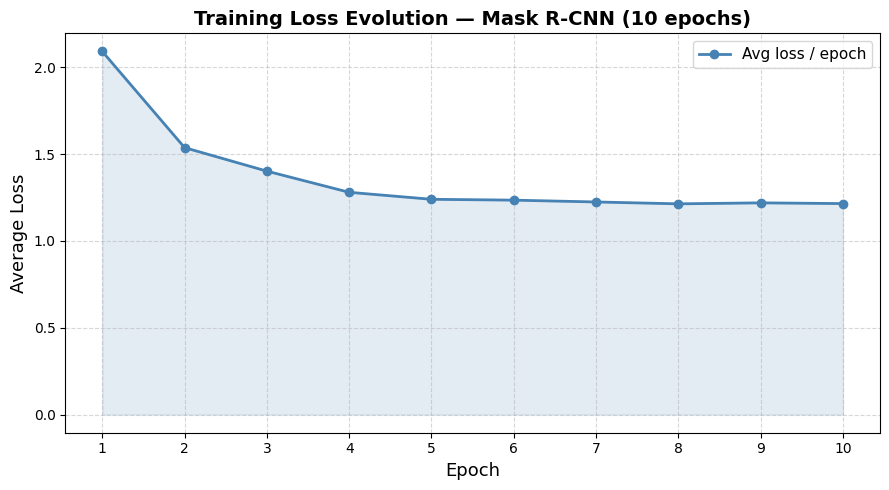

Loss curve saved to training_loss_curve.png


In [6]:
# ── Training loss curve ────────────────────────────────────────────────────────
epochs_x = range(1, len(epoch_losses) + 1)

plt.figure(figsize=(9, 5))
plt.plot(epochs_x, epoch_losses,
         marker='o', linewidth=2, color='steelblue', label='Avg loss / epoch')
plt.fill_between(epochs_x, epoch_losses, alpha=0.15, color='steelblue')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Average Loss', fontsize=13)
plt.title('Training Loss Evolution — Mask R-CNN (10 epochs)', fontsize=14, fontweight='bold')
plt.xticks(epochs_x)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('training_loss_curve.png', dpi=150)
plt.show()
print('Loss curve saved to training_loss_curve.png')


C:\Users\silue\AppData\Local\Temp\ipykernel_58492\1732071610.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', 10)


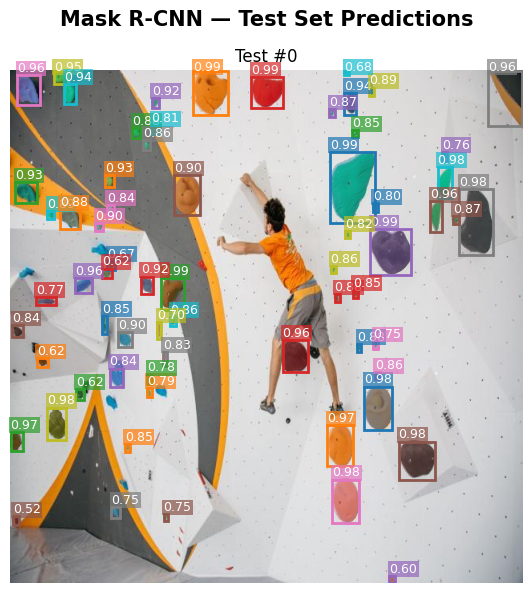

In [7]:
# Show predictions on 4 random test images (tweak num_images / score_threshold as needed)
visualize_test_predictions(model, dataset_test, device, num_images=4, score_threshold=0.5)
